In [1]:
#! /usr/bin/python3
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import sys, os, subprocess
import json as json
from tqdm import tqdm
import pandas as pd
import argparse
from pathlib import Path
import seaborn as sns
import matplotlib.tri as tri
sys.path.append("../")
from libraries.functions import *
from libraries.particles import *
from libraries.exhumation import *
import plotly.graph_objects as go

/home/vturino/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
data_dir = "/home/vturino/PhD/projects/exhumation/plots/single_models"
output_dir = "kinematic_mu0.13_basalt7.5km_sed1km_cttV"
files_dir = f"{data_dir}/{output_dir}/txt_files/stagnant"


In [3]:
data = pd.read_csv(f"{data_dir}/{output_dir}/txt_files/stagnant_maxima.txt", sep="\t")

rocks_loc = '/home/vturino/PhD/projects/exhumation/rock_record/'

rocks = pd.read_excel(f"{rocks_loc}rocks_agard2018.xlsx")
rocks = rocks[rocks["AREA"] != "Metamorphic Soles"]

/tmp/ipykernel_1400042/2870529881.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[f"T{i+1}"], data[f"P{i+1}"], s=1, marker="o", cmap="viridis", label=f"P{i+1}")


(0.0, 900.0)

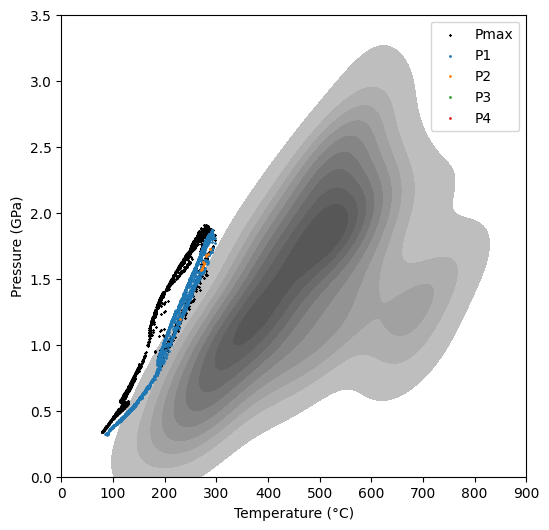

In [4]:
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.kdeplot(data = rocks, x = rocks["T"], y = "P", fill=True, color = "grey", levels=10)
plt.scatter(data["Tmax"], data["Pmax"], s=1, marker="x", color = "k", label="Pmax")
for i in range(0,4):
    plt.scatter(data[f"T{i+1}"], data[f"P{i+1}"], s=1, marker="o", cmap="viridis", label=f"P{i+1}")
plt.legend()
plt.xlabel("Temperature (°C)")
plt.ylabel("Pressure (GPa)")
plt.ylim(0, 3.5)
plt.xlim(0, 900)

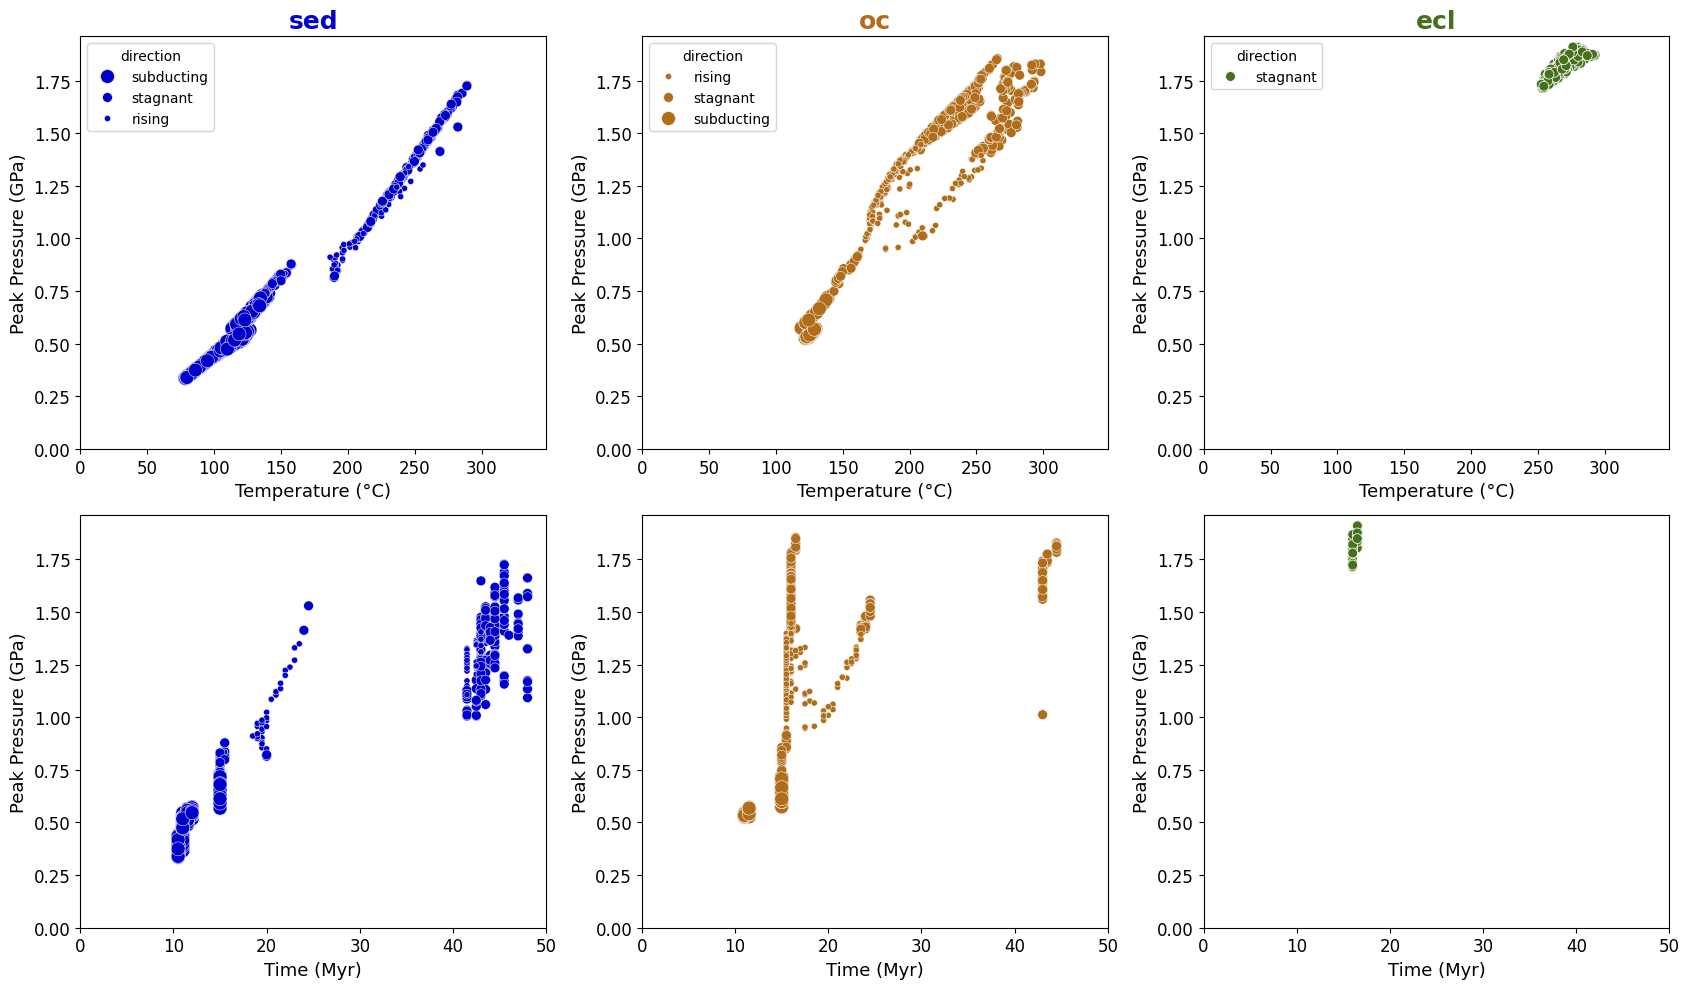

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

lnumber = len(data.lithology.unique())
fig, ax = plt.subplots(2, lnumber, figsize=(17, 10)) 

size = {
    "subducting": 100,
    "stagnant": 50,
    "rising": 20
}

color = {
    "Pmax": "#377eb8",  # Blue
    "P1": "#e41a1c",    # Red
    "P2": "#4daf4a",    # Green
    "P3": "#984ea3"     # Purple
}

colors_tmax = {
        "sed": "mediumblue",
        "oc": "#B06D1A",
        "ecl": "#45701C",
        "serp": "brown"
    }

# Loop over each unique lithology to create separate subplots
for ind_l, l in enumerate(data['lithology'].unique()):
    # Filter data and size values for each lithology
    lithology_data = data[data["lithology"] == l]

    
    # Plot Tmax vs Pmax for the current lithology
    sns.scatterplot(
        data=lithology_data, 
        x="Tmax", 
        y="Pmax", 
        ax=ax[0, ind_l], 
        size = "direction", sizes=size,
        legend = True,
        color = colors_tmax[l]
    )
    
    # # Loop to plot additional (T1, P1), (T2, P2), (T3, P3) points for each lithology
    # for i in range(3):
    #     sns.scatterplot(
    #         data=lithology_data, 
    #         x=f"T{i+1}", 
    #         y=f"P{i+1}", 
    #         ax=ax[0, ind_l], 
    #         size = "direction", sizes=size,
    #         color = color[f"P{i+1}"],
    #         legend= False
    #     )

    # # Create a custom legend for size
    # size_legend = [Line2D([0], [0], marker='o', color='w', label=key, markersize=size[key] / 10, markerfacecolor='grey') 
    #             for key in size]
    # size_labels = list(size.keys())

    # # Create a custom legend for color
    # color_legend = [Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color[key]) 
    #                 for key in color]
    # color_labels = list(color.keys())

    # # Place legends on the last subplot
    # ax[0, 0].legend(handles=size_legend, labels=size_labels, title="Direction", loc="upper left")
    # ax[0, 1].legend(handles=color_legend, labels=color_labels, title="Timing", loc="upper left")

    

    # # Customize each axis
    ax[0, ind_l].set_xlabel("Temperature (°C)", fontsize=13)
    ax[0, ind_l].set_ylabel("Peak Pressure (GPa)", fontsize=13)
    ax[0, ind_l].tick_params(axis='both', which='major', labelsize=12)
    ax[0, ind_l].set_ylim(0, data["Pmax"].max() + 0.05)
    ax[0, ind_l].set_xlim(0, data["Tmax"].max() + 50)
    ax[0, ind_l].set_title(l, fontsize=18, fontweight='bold', color = colors_tmax[l])
    
    # Plot time vs. pressure data in the second row of subplots
    sns.scatterplot(
        data=lithology_data, 
        x="timePmax", 
        y="Pmax", 
        size = "direction", sizes=size,
        ax=ax[1, ind_l],
        legend = False,
        color = colors_tmax[l],
    )

    # # Loop to plot additional (timeP1, P1), (timeP2, P2), (timeP3, P3) points for each lithology
    # for i in range(3):
    #     sns.scatterplot(
    #         data=lithology_data, 
    #         x=f"timeP{i+1}", 
    #         y=f"P{i+1}", 
    #         ax=ax[1, ind_l],
    #         color = color[f"P{i+1}"],
    #         legend= False
    #     )
        
    # Customize the time-pressure axes
    # ax[1, ind_l].legend()
    ax[1, ind_l].set_xlabel("Time (Myr)", fontsize=13)
    ax[1, ind_l].set_ylabel("Peak Pressure (GPa)", fontsize=13)
    ax[1, ind_l].tick_params(axis='both', which='major', labelsize=12)
    ax[1, ind_l].set_ylim(0, data["Pmax"].max() + 0.05)
    ax[1, ind_l].set_xlim(0, 50)




plt.tight_layout()
plt.savefig(f"{data_dir}/{output_dir}/stagnant_maxima.png", dpi=300)
# plt.show()


In [7]:
# fig, ax = plt.subplots(2, lnumber+1, figsize=(15, 10))

# sns.scatterplot(data = data, x = "Tmax", y = "Pmax", hue = "lithology", size = "direction", sizes=size, ax=ax[0, 0])
# sns.scatterplot(data = data, x = "timePmax", y = "Pmax", hue = "lithology", size = "direction", sizes=size, ax=ax[1, 0], legend = False)
# ax[0,0].set_title("Peak Pressure")


# for i in range(3):
#     sns.scatterplot(data = data, x = f"T{i+1}", y = f"P{i+1}", hue = "lithology", size = "direction", sizes=size, ax=ax[0, i+1], legend = False)
#     sns.scatterplot(data = data, x = f"timeP{i+1}", y = f"P{i+1}", hue = "lithology", size = "direction", sizes=size, ax=ax[1, i+1], legend = False)
#     ax[0,i+1].set_title(f"P{i+1}")

In [8]:
stagnant = data[data["direction"] == "stagnant"]
subducting = data[data["direction"] == "subducting"]
rising = data[data["direction"] == "rising"]

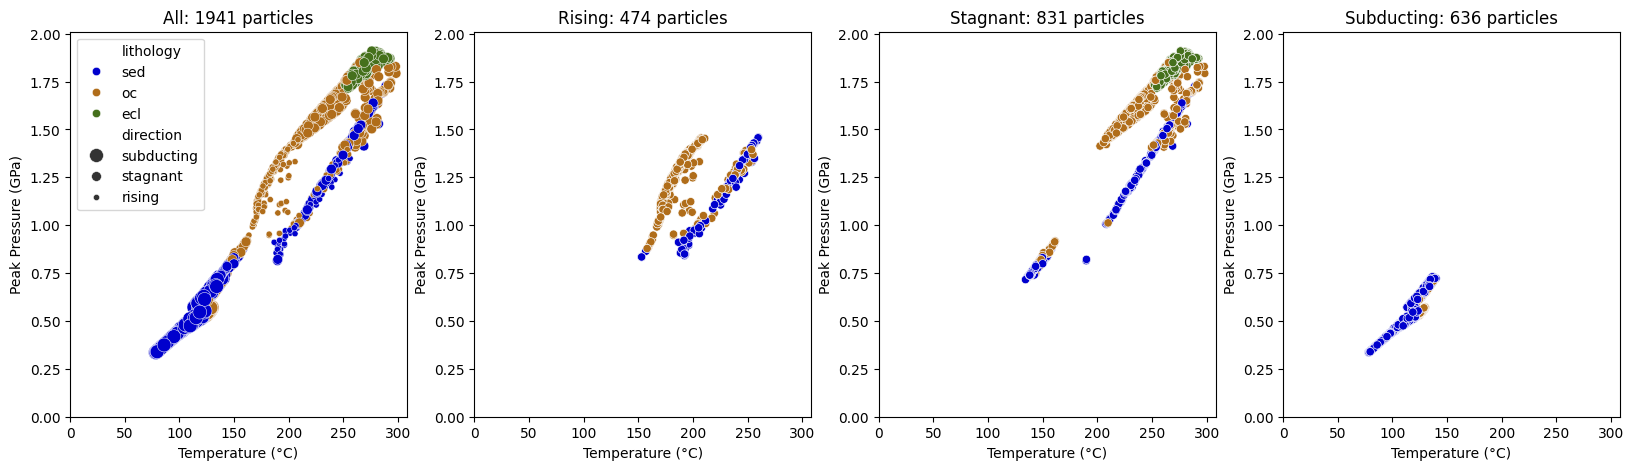

In [133]:
colors_tmax = {
            "sed": "mediumblue",
            "oc": "#B06D1A",
            "ecl": "#45701C",
            "serp": "brown"
        }
ax, fig = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(data = data, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[0], size="direction", sizes=size)
fig[0].set_title(f"All: {len(data)} particles")
sns.scatterplot(data = rising, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[1], legend=False)
fig[1].set_title(f"Rising: {len(rising)} particles")
sns.scatterplot(data = stagnant, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[2], legend=False)
fig[2].set_title(f"Stagnant: {len(stagnant)} particles")
sns.scatterplot(data = subducting, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[3], legend=False)
fig[3].set_title(f"Subducting: {len(subducting)} particles")

for i in range(4):
    fig[i].set_xlim(0, max(data["Tmax"])+10)
    fig[i].set_ylim(0, max(data["Pmax"])+0.1)
    fig[i].set_xlabel("Temperature (°C)")
    fig[i].set_ylabel("Peak Pressure (GPa)")


/tmp/ipykernel_1063721/779991352.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = rising, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 1], legend=False)
/tmp/ipykernel_1063721/779991352.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = stagnant, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 2], legend=False)


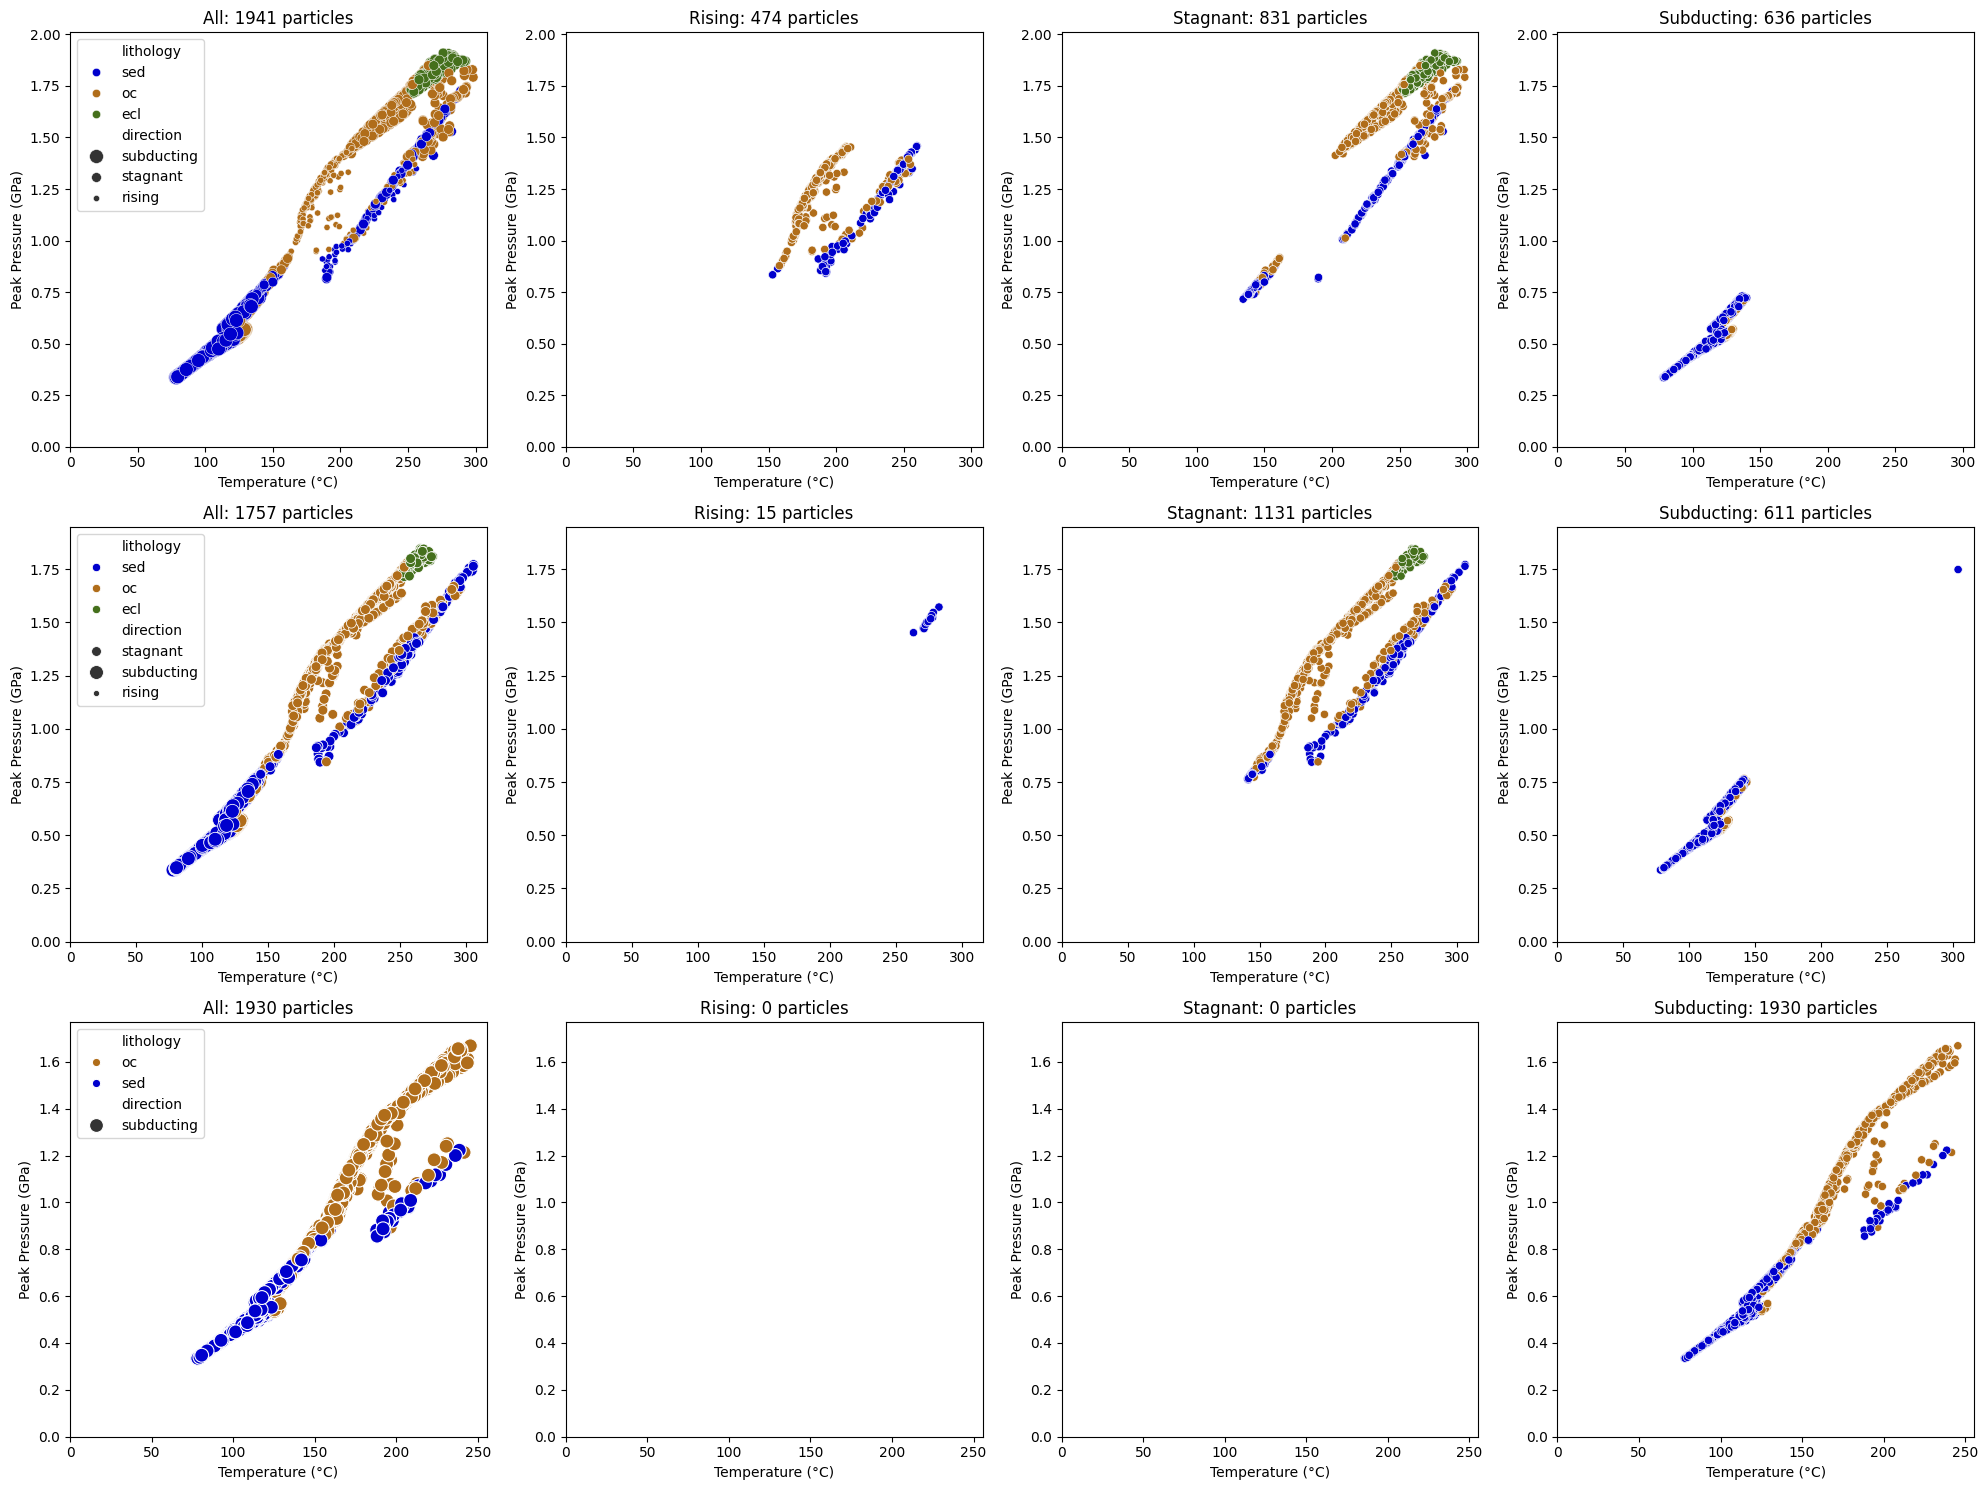

In [143]:
models = ["kinematic_mu0.13_basalt7.5km_sed1km_cttV", "kinematic_mu0.13_basalt7.5km_sed1km_Vto50pc", "kinematic_mu0.13_basalt7.5km_sed1km_Vto0"]
colors_tmax = {
            "sed": "mediumblue",
            "oc": "#B06D1A",
            "ecl": "#45701C",
            "serp": "brown"
        }

sizes = {
    "subducting": 80,
    "stagnant": 20,
    "rising": 50
}

ax, fig = plt.subplots(3, 4, figsize=(20, 15))
for m, model in enumerate(models):
    data = pd.read_csv(f"{data_dir}/{model}/txt_files/stagnant_maxima.txt", sep="\t")
    stagnant = data[data["direction"] == "stagnant"]
    subducting = data[data["direction"] == "subducting"]
    rising = data[data["direction"] == "rising"]

    
    sns.scatterplot(data = data, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 0], size="direction", sizes=size)
    fig[m, 0].set_title(f"All: {len(data)} particles")

    sns.scatterplot(data = rising, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 1], legend=False)
    fig[m, 1].set_title(f"Rising: {len(rising)} particles")

    sns.scatterplot(data = stagnant, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 2], legend=False)
    fig[m, 2].set_title(f"Stagnant: {len(stagnant)} particles")

    sns.scatterplot(data = subducting, x = "Tmax", y = "Pmax", hue = "lithology", palette=colors_tmax, ax=fig[m, 3], legend=False)
    fig[m, 3].set_title(f"Subducting: {len(subducting)} particles")

    for i in range(4):
        fig[m, i].set_xlim(0, max(data["Tmax"])+10)
        fig[m, i].set_ylim(0, max(data["Pmax"])+0.1)
        fig[m, i].set_xlabel("Temperature (°C)")
        fig[m, i].set_ylabel("Peak Pressure (GPa)")

plt.tight_layout()
plt.savefig(f"{data_dir}/stagnant_maxima_all_models.png", dpi=300)
    





Text(0.5, 1.0, 'stagnant')

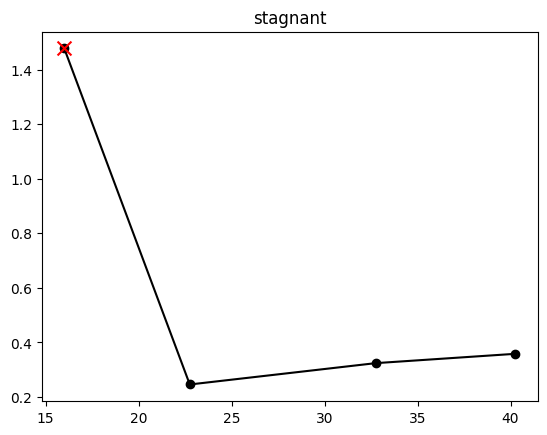

In [95]:
pt = np.zeros((data["numberP"].max(), 2))

p = 10

pt[0, 0] = data["timePmax"].iloc[p]
pt[0, 1] = data["Pmax"].iloc[p]

for i in range(1, data["numberP"].max()):
    pt[i, 0] = data[f"timeP{i}"].iloc[0]
    pt[i, 1] = data[f"P{i}"].iloc[0]

pt = pt[pt[:, 0].argsort()]

plt.plot(pt[:,0], pt[:,1], marker="o", color="k")
plt.scatter(data["timePmax"].iloc[p], data["Pmax"].iloc[p], s=100, marker="x", color="r", zorder=10)
plt.title(data["direction"].iloc[p])

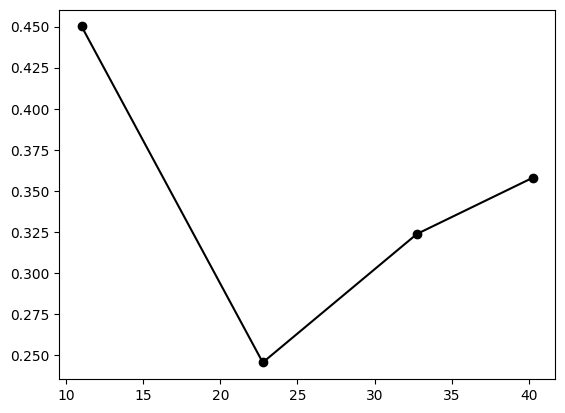

In [108]:
for p in range(0, 1):
    pt = np.zeros((data["numberP"].max(), 2))
    pt[0, 0] = data["timePmax"].iloc[p]
    pt[0, 1] = data["Pmax"].iloc[p]
    for i in range(1, data["numberP"].max()):
        pt[i, 0] = data[f"timeP{i}"].iloc[0]
        pt[i, 1] = data[f"P{i}"].iloc[0]
    pt = pt[pt[:, 0].argsort()]

    diff = np.zeros(data["numberP"].max()-1)

    for j in range(len(pt)-1):
        if pt[j, 0] >= data["timePmax"].iloc[p]:
            diff[j] = pt[j, 1] - pt[j+1, 1]
    plt.plot(pt[:,0], pt[:,1], marker="o", color="k")